<a href="https://colab.research.google.com/github/Dain777666/ESAA_25-2/blob/main/OB_WEEK10_FRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2.4 파이토치 코드 맛보기


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dataset = pd.read_csv("car_evaluation.csv")
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='count'>

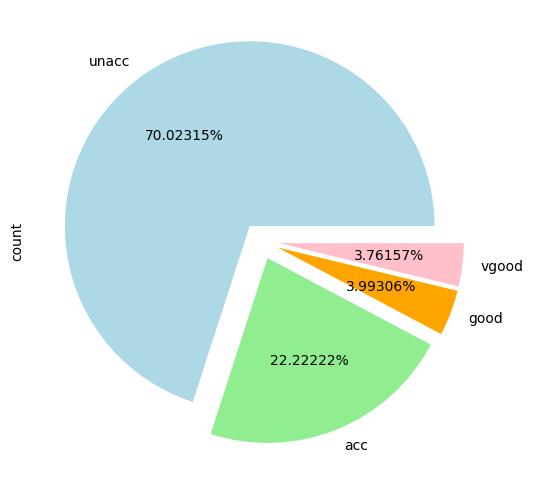

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind="pie", autopct = '%0.05f%%',
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'],
                                   explode = [0.1, 0.1, 0.1, 0.1])

✅ 결과에 따르면 대부분의 자동차(70%)는 허용 불가능한 상태에 있고 20%만 허용 가능한 수준. 즉, 양호한 상태의 자동차 비율이 매우 낮음.

< 범주형 데이터를 텐서로 >

- 범주형 데이터 -> dataset[category] -> 넘파이 배열 -> 텐서

- 범주형 데이터(단어)를 숫자(넘파이 배열)로 변환하기 위해 cat.codes를 사용함

-  cat.codes는 어떤 클래스가 어떤 숫자로 매핑되어 있는지 확인이 어려움

In [4]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

< np.stack()과 np.concatenate() >

- 두 메서드는 차원의 유지 여부에 대한 차이가 있음

-  np.concatenate()는 선택한 축{axis)을 기준으로 두 개의 배열을 연결함 -> 차원 그대로

-  np.stack()은 배열들을 새로운 축으로 합쳐줌 -> 차원이 바뀜

In [5]:
categorical_data = torch.tensor(categorical_data, dtype = torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [6]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() #1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


< 텐서의 차원 변경 >

- ravel(), reshape(), flatten() 이용

```
a = np .array([[1, 2], [3, 4]])
print(a.ravel())
print(a.reshape(-1))
print(a.flatten( ))
```


< 워드 임베딩 >

- 유사한 단어끼리 유사하게 인코딩되도록 표현하는 방법

- 높은 차원의 임베딩일수록 단어 간의 세부적인 관계를 잘 파악할 수 있음 -> 따라서, 단일 숫자로 변환된 넘파이 배열을 N차원으로 변경하여 사용함

- 배열을 N차원으로 변환하기 위해 먼저 모든 범주형 칼럼에 대한 임베딩 크기(벡터 차원)를 정의함 -> 칼럼의 고유 값 수를 2로 나누는 것을 많이 사용함





In [7]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in
                            categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in
                              categorical_column_sizes ]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [8]:
total_records = 1728
test_records = int(total_records * .2) #전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [9]:
class Model(nn.Module): ### 1
    def __init__(self, embedding_size, output_size, layers, p=0.4): ### 2
        super().__init__() ### 3
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,
                                     nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols #입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size 변수에 저장

        for i in layers: ### 4
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical): ### 5
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
           embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) #넘파이의 concatenate와 같지만 대상이 텐서
        x = self.embedding_dropout(x)
        x = self.layers(x)

        return x

1. 클래스(class) 형태로 구현되는 모벨은 nn.Module을 상속받음

2.  __ init __()은 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도로 사용하며，객체가 생성될 때 자동으로 호출됨

- self: 첫 번째 파라미터는 self를 지정해야 하며 자기 자신을 의미함
- embedding_size: 범주형 칼럼의 임베딩 크기
- output_size: 출력층의 크기
- layers: 모든 계층에 대한 목록
- p: 드롭 아웃(기본값은 0.5)

3. super().__ init __()은 부모 클래스(nn. Module)에 접근할 때 사용함

4. 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가함

- Linear: 선형 계층
- ReLU: 활성화 함수로 사용
- BatchNorm1d: 배치 정규화 용도로 사용
- Dropout: 과적합 방지에 사용

5. forward() 함수는 학습 데이터를 입력받아서 연산을 진행함

In [10]:
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda') # GPU가 있다면 GPU를 사용
else:
    device = torch.device('cpu') # GPU가 없다면 CPU를 사용

In [13]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs): # for문은 500회 반복되며, 각 반복마다 손실 함수가 오차를 계산
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 aggregated_losses에 추가

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward() # 가중치를 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트


print(f'epoch: {i:3} loss: {single_loss.item():10.10f}') # 오차가 25 에포크마다 출력

epoch:   1 loss: 1.50502551
epoch:  26 loss: 1.35448992
epoch:  51 loss: 1.26600564
epoch:  76 loss: 1.18006670
epoch: 101 loss: 1.06146276
epoch: 126 loss: 0.93736035
epoch: 151 loss: 0.82297713
epoch: 176 loss: 0.73798651
epoch: 201 loss: 0.68326670
epoch: 226 loss: 0.64664024
epoch: 251 loss: 0.61977983
epoch: 276 loss: 0.63137192
epoch: 301 loss: 0.61108851
epoch: 326 loss: 0.59237796
epoch: 351 loss: 0.58992493
epoch: 376 loss: 0.59021395
epoch: 401 loss: 0.57564092
epoch: 426 loss: 0.58091688
epoch: 451 loss: 0.57792568
epoch: 476 loss: 0.57487100
epoch: 500 loss: 0.5794149637


In [14]:
test_outputs = test_outputs.to(device = device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.56433320


In [15]:
print(y_val[:5])

tensor([[ 2.5247,  1.3611, -2.8061, -2.8025],
        [ 2.2300,  1.1232, -3.1789, -2.8962],
        [ 2.1879,  1.1275, -2.9600, -2.8227],
        [ 2.8792,  1.5693, -3.7834, -3.7179],
        [ 2.3646,  1.2284, -2.7701, -2.6479]])


In [16]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[259   0]
 [ 85   1]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       1.00      0.01      0.02        86

    accuracy                           0.75       345
   macro avg       0.88      0.51      0.44       345
weighted avg       0.81      0.75      0.65       345

0.7536231884057971


< 성능 평가 지표 >

- True Positive: 모델(분류기)이 '1'이라고 예측했는데 실제 값도 '1'인 경우
- True Negative: 모델(분류기)이 '0'이라고 예측했는데 실제 값도 '0'인 경우
- False Positive: 모델(분류기)이 '1'이라고 예측했는데 실제 값도 '0'인 경우 -> 1종의 오류
- False Negative: 모델(분류기)이 '0'이라고 예측했는데 실제 값도 '1'인 경우 -> 2종 오류

(1) 정확도: 전체 예측 건수에서 정답을 맞힌 건수의 비율

(2) 재현율: 실제로 정답이 1이라고 할 때 모델도 1로 예측한 비율

(3) 정밀도: 모델이 1이라고 예측한 것 중에서 실제로 정답이 1인 비율

(4) F1-스코어: 일반적으로 정밀도와 재현율은 트레이드오프(trade-off) 관계이며, 정밀도와 재현율의 조화 평균(harmonic mean)